In [1]:
import os

os.chdir('../..')

In [2]:
import glob
from os.path import basename, join, splitext

import numpy as np
from numpy.linalg import norm
import pandas as pd

import modules.point_processing as pp


In [3]:
def combine_dataframes(load_dir, trial_names):
    """Combine dataframes from different walking trials."""
    dataframe_dict = {}

    for trial_name in trial_names:
        dataframe_dict[trial_name] = pd.read_pickle(
            join(load_dir, trial_name) + '.pkl')

    return pd.concat(dataframe_dict)


In [4]:
kinect_dir = join('data', 'kinect')

df_truth = pd.read_pickle('results/dataframes/df_truth.pkl')
trial_names = df_truth.index.get_level_values(0).unique().values

df_hypo = combine_dataframes(
    join(kinect_dir, 'processed', 'hypothesis'), trial_names)
df_selected = combine_dataframes(join(kinect_dir, 'best_pos'), trial_names)
df_assigned = combine_dataframes(join(kinect_dir, 'assigned'), trial_names)

foot_parts = ['L_FOOT', 'R_FOOT']

# Truth positions on frames with head and both feet
df_truth = df_truth.loc[:, ['HEAD'] + foot_parts].dropna()

# Drop index level for walking pass
# This gives it the same index as the other dataframes
df_assigned.index = df_assigned.index.droplevel(1)

# %% Take frames with truth and selected positions

index_intersect = df_truth.index.intersection(df_selected.index)

df_truth = df_truth.loc[index_intersect]
df_hypo = df_hypo.loc[index_intersect]
df_selected = df_selected.loc[index_intersect]
df_assigned = df_assigned.loc[index_intersect]

In [5]:
file_paths = sorted(glob.glob(join(kinect_dir, 'best_pos_radii', '*.pkl')))

dataframe_dict = {}

for file_path in file_paths:
    file_name = splitext(basename(file_path))[0]
    trial_name, radius = file_name.split('_radius_')
    
    dataframe_dict[(float(radius), trial_name)] = pd.read_pickle(file_path)
   

df_radii = pd.concat(dataframe_dict)
df_radii.index.names = ['radius', 'trial_name', 'frame']

radii = df_radii.index.get_level_values(0).unique().values

In [6]:
proposals = df_hypo.FOOT.values

truth_l = np.stack(df_truth.L_FOOT)
truth_r = np.stack(df_truth.R_FOOT)

# Create modified truth
truth_mod_l = pp.closest_proposals(proposals, np.stack(df_truth.L_FOOT))
truth_mod_r = pp.closest_proposals(proposals, np.stack(df_truth.R_FOOT))


#     acc_matched = pp.double_position_accuracy(
#         matched_l, matched_r, truth_l, truth_r, max_dist=10)
    
#     acc_matched_mod = pp.double_position_accuracy(
#         matched_l, matched_r, truth_mod_l, truth_mod_r, max_dist=10)
    
#     print(radius, acc_matched, acc_matched_mod)

In [7]:
radii = np.arange(0, 10, 1)

truth_accs, truth_mod_accs = [], []
mean_dists, mean_dists_mod = [], []

for radius in radii:

    df_selected = df_radii.loc[radius].loc[index_intersect]
    
    selected_l = np.stack(df_selected.L_FOOT)
    selected_r = np.stack(df_selected.R_FOOT)
    
    # Match selected positions with truth
    matched_l, matched_r = pp.match_pairs(selected_l, selected_r, truth_l,
                                          truth_r)
    
    
    matched_lr = np.vstack((matched_l, matched_r))
    truth_lr = np.vstack((truth_l, truth_r))
    truth_mod_lr = np.vstack((truth_mod_l, truth_mod_r))
    
    mean_dists.append(norm(matched_lr - truth_lr, axis=1).mean())
    mean_dists_mod.append(norm(matched_lr - truth_mod_lr, axis=1).mean())
    
    truth_accs.append(pp.double_position_accuracy(matched_l, matched_r, truth_l, truth_r))
    truth_mod_accs.append(pp.double_position_accuracy(matched_l, matched_r, truth_mod_l, truth_mod_r))

In [8]:
import matplotlib.pyplot as plt

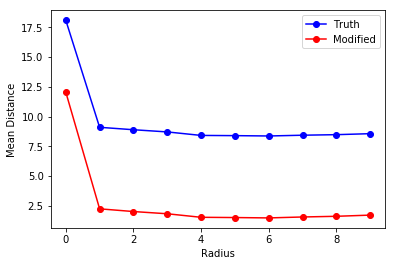

In [9]:
plt.figure()

plt.plot(radii, mean_dists, '-o', c='b')
plt.plot(radii, mean_dists_mod, '-o', c='r')

plt.xlabel('Radius')
plt.ylabel('Mean Distance')

plt.legend(['Truth', 'Modified'])

plt.show()

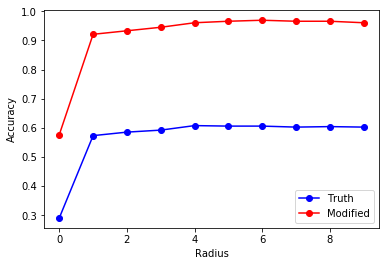

In [10]:
plt.figure()

plt.plot(radii, truth_accs, '-o', c='b')
plt.plot(radii, truth_mod_accs, '-o', c='r')

plt.xlabel('Radius')
plt.ylabel('Accuracy')

plt.legend(['Truth', 'Modified'])

plt.show()